In [2]:
%matplotlib inline
import matplotlib.pylab as pl

import pandas as pd
import numpy as np

import sklearn as sk
import contextlib
import statsmodels.api as sm
import scipy.signal
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn import decomposition


sns.set()

In [3]:
#http://stackoverflow.com/questions/2891790/pretty-printing-of-numpy-array
#set a function to manage the print options of specific arrays
@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    yield 
    np.set_printoptions(**original)

**Import Data, Check Healthiness, Verify Can Drop NAs**

(this is a preliminary run through, using only NY County, All Industry Sectors, quarterly data from 2000 - 2014)

In [4]:
#reading in QWI indicators for the 4 counties in NYC (New York, Kings)

df = pd.read_csv('~/Documents/GRA/QWI_indicators/qwi_5c2543d712bc416f82683ab99e1517f6.csv')

In [5]:
#print out a list of columns
#df.columns

In [6]:
#remove the flags, which have a lowercase s followed by a capitalized column name
columns_no_flags = [word for word in df.columns if not word[1].isupper()]

#subset to new DF with no flags
df = df[columns_no_flags]
df.columns = [x.replace('.','_') for x in df.columns]

In [7]:
def print_full(x):
    #this function takes in a dataframe and prints the head of the df with all columns displayed
    #it then resets back to the default column display afterwards
    pd.set_option('display.max_columns', 500)
    print(x.head(10))
    pd.reset_option('display.max_columns')
    
#print_full(df)
#df.dtypes

In [8]:
#create new column 'period' that maps the year and quarter
df['period'] = df.year.map(str) + "_" + df.quarter.map(str)


In [9]:
#want data for Manhattan (county = 'New York, NY')
df_ny = df[df.geography_label_value == 'New York, NY']
#only using data from all industries in this example
mask = (df_ny.industry == '00')
df_ny_all = df_ny[mask]
#set the period as the index, so we can keep it when we go to all numerics
df_ny_all = df_ny_all.set_index(df_ny_all.period)


In [10]:
#select numeric columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
data = df_ny_all.select_dtypes(include=numerics)

#move period back from index
data.reset_index(level=0, inplace=True)



In [11]:
#drop geography, sex, firmage, firmsize
data.drop(['geography', 'sex', 'firmage', 'firmsize'], axis=1, inplace=True)

/usr/local/lib/python3.4/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


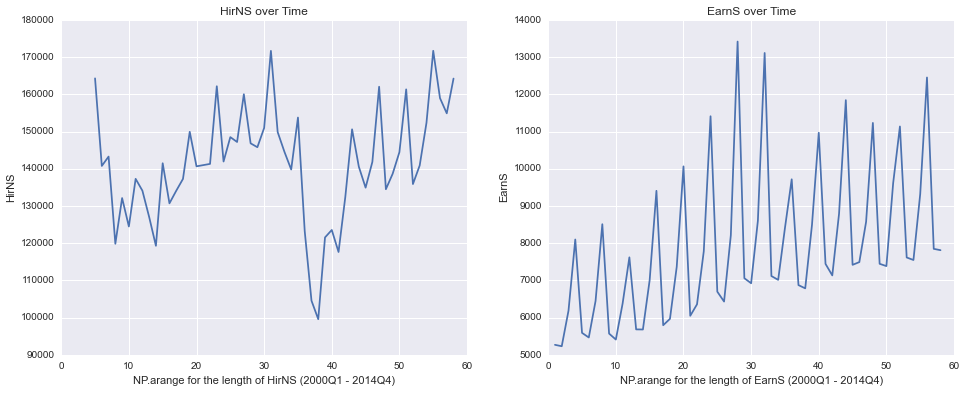

In [12]:
#before drop the NANs, verify position
#from printout, can see there are 6 in HirNS, 2 in EarnS

#check number of NaNs before Drop the values
#print(data.isnull().sum())

#points_ax1 = np.arange(len(data.HirNS))

fig, ((ax1, ax2)) = pl.subplots(figsize=(16,6), nrows=1, ncols=2)
ax1.plot(np.arange(len(data.HirNS)), data.HirNS, label = 'all data')
ax1.set_xlabel('NP.arange for the length of HirNS (2000Q1 - 2014Q4)')
ax1.set_ylabel('HirNS')
ax1.set_title('HirNS over Time')

ax2.plot(np.arange(len(data.EarnS)), data.EarnS, label = 'all data')
ax2.set_xlabel('NP.arange for the length of EarnS (2000Q1 - 2014Q4)')
ax2.set_ylabel('EarnS')
ax2.set_title('EarnS over Time')


#based off the graph below, these are in early 2000 and then again in late 2014. Can now drop them
data = data.dropna()
data = data.reset_index()

In [13]:
data.index = pd.Index(pd.date_range(pd.to_datetime('04/1/2001'), pd.to_datetime('06/30/2014'),freq='Q'))

In [14]:
#cacluate percent change in new hires and add to dataframe
HirN_per = [0]
for i in np.arange(len(data['HirN'])-1):
#    while i < max(np.arange(len(data['HirN']))):
    #for i in len[data.HirN]:
    change = (data.ix[i+1,'HirN'] - data.ix[i,'HirN'])/data.ix[i,'HirN']
    HirN_per.append(change)
#print (HirN_per)

data['HirN_per'] = HirN_per

In [15]:
# add in NY county unemployment rates
df = pd.read_excel('/Users/carlyle/Documents/GRA/QWI_indicators/ny_county_uer.xlsx')
df = df.ix[5:57]
data['NYC_UER'] = (df['ny_uer'].values/100)

In [16]:
data['LMP'] = data['HirN_per'] / data['NYC_UER']

**Scatter Matrix and Basic Data Visualization**

In [17]:
#sns.pairplot(data, hue = 'quarter')

In [18]:
cols = list(data.columns)[4:-2]

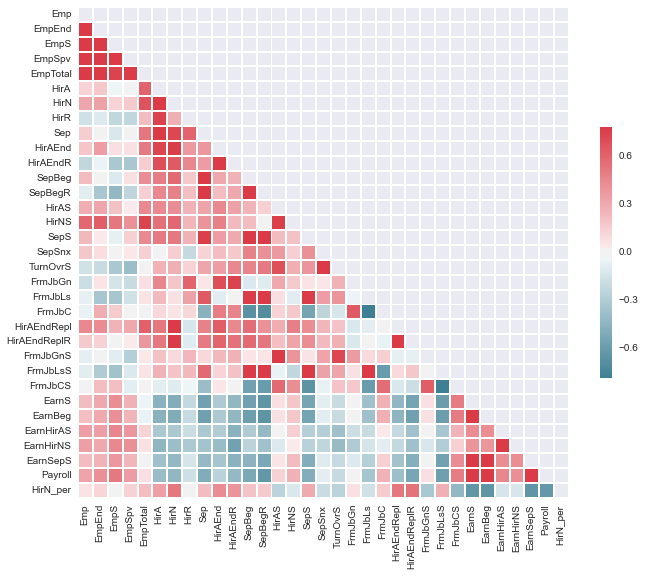

In [19]:
#Correlation Matrix for input variables

# Compute the correlation matrix
corr = data[cols].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = pl.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, #xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

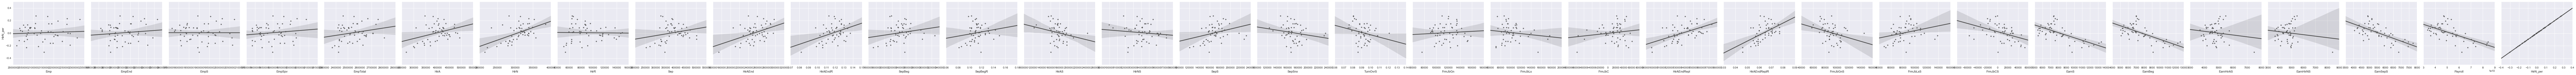

In [21]:
# Every input variable vs. Percent change in new hires
# graphs have a simple linear regression bar through plot with shaded 95% CI zone
# double click to zoom in 

g = sns.PairGrid(data, y_vars=["HirN_per"], x_vars=cols, size=4)
g.map(sns.regplot, color=".3")
g.set(ylim=(-0.5, 0.5))

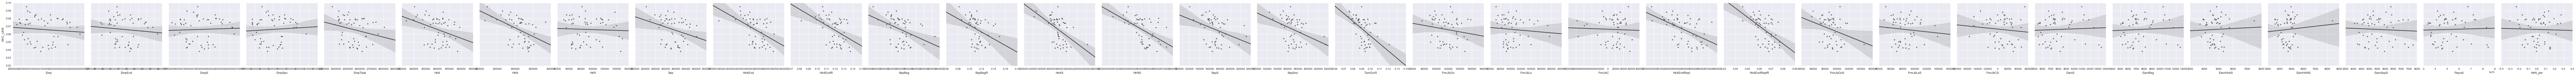

In [22]:
# Every input variable vs. Unemployment Rates
# graphs have a simple linear regression bar through plot with shaded 95% CI zone
# double click to zoom in 

g = sns.PairGrid(data, y_vars=["NYC_UER"], x_vars=cols, size=4)
g.map(sns.regplot, color=".3")
g.set(ylim=(0.02, 0.1))

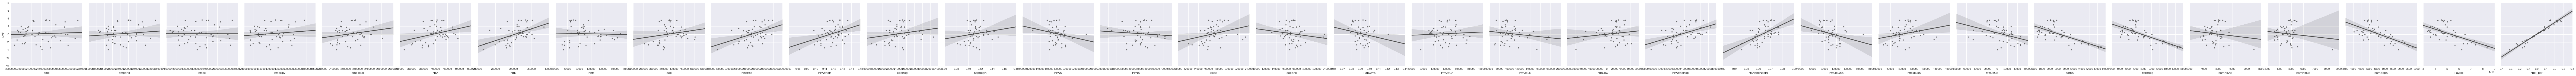

In [46]:
# Every input variable vs. Unemployment Rates
# graphs have a simple linear regression bar through plot with shaded 95% CI zone
# double click to zoom in 

g = sns.PairGrid(data, y_vars=["LMP"], x_vars=cols, size=4)
g.map(sns.regplot, color=".3")
#g.set(ylim=(-.5, 0.5))

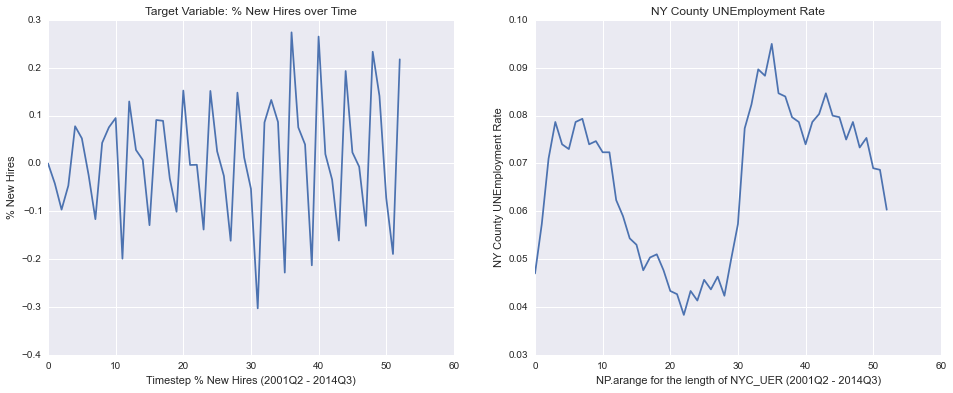

In [24]:
fig, ((ax1, ax2)) = pl.subplots(figsize=(16,6), nrows=1, ncols=2)
ax1.plot(np.arange(len(data.HirN_per)), data.HirN_per, label = 'all data')
ax1.set_xlabel('Timestep % New Hires (2001Q2 - 2014Q3)')
ax1.set_ylabel('% New Hires')
ax1.set_title('Target Variable: % New Hires over Time')

ax2.plot(np.arange(len(data.NYC_UER)), data.NYC_UER, label = 'all data')
ax2.set_xlabel('NP.arange for the length of NYC_UER (2001Q2 - 2014Q3)')
ax2.set_ylabel('NY County UNEmployment Rate')
ax2.set_title('NY County UNEmployment Rate')


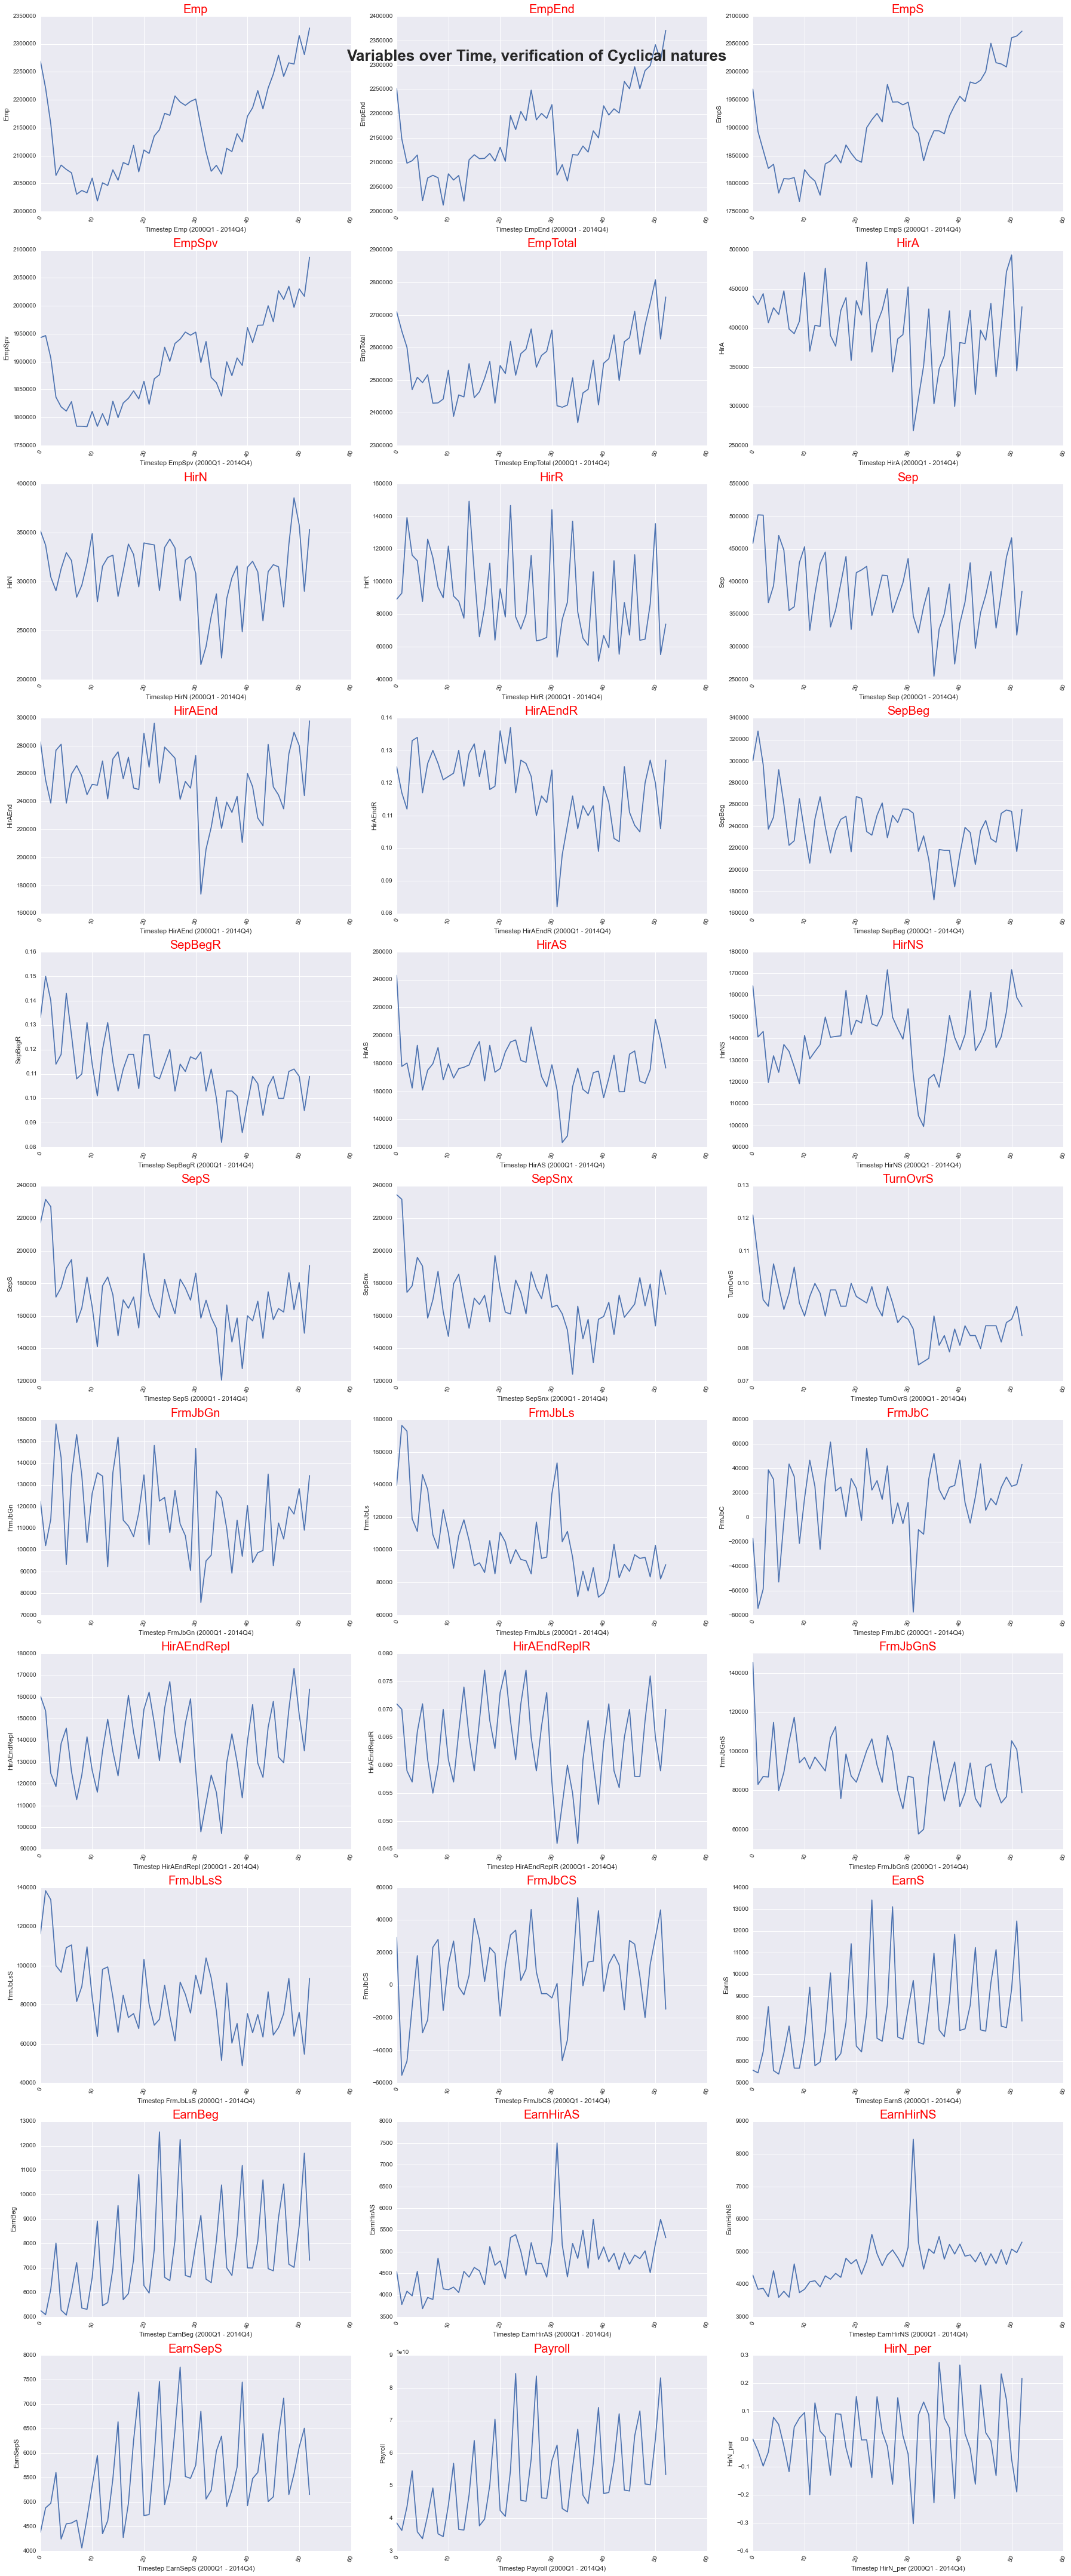

In [25]:
fig = pl.figure(figsize=(25,60))
fig.suptitle('Variables over Time, verification of Cyclical natures', fontweight='bold', fontsize=26)

x = 1
for i in cols:
    ax1 = fig.add_subplot(11,3,x)
    fig.tight_layout()
    ax1.plot(np.arange(len(data[i])), data[i], label = 'all data')
    ax1.set_xlabel('Timestep {0} (2000Q1 - 2014Q4)'.format(i))
    ax1.set_ylabel('{0}'.format(i))
    ax1.set_title('Target Variable: % New Hires over Time')
    pl.xticks(rotation = 70)
    ax1.set_title(i, fontsize=20, color='r')
    x +=1

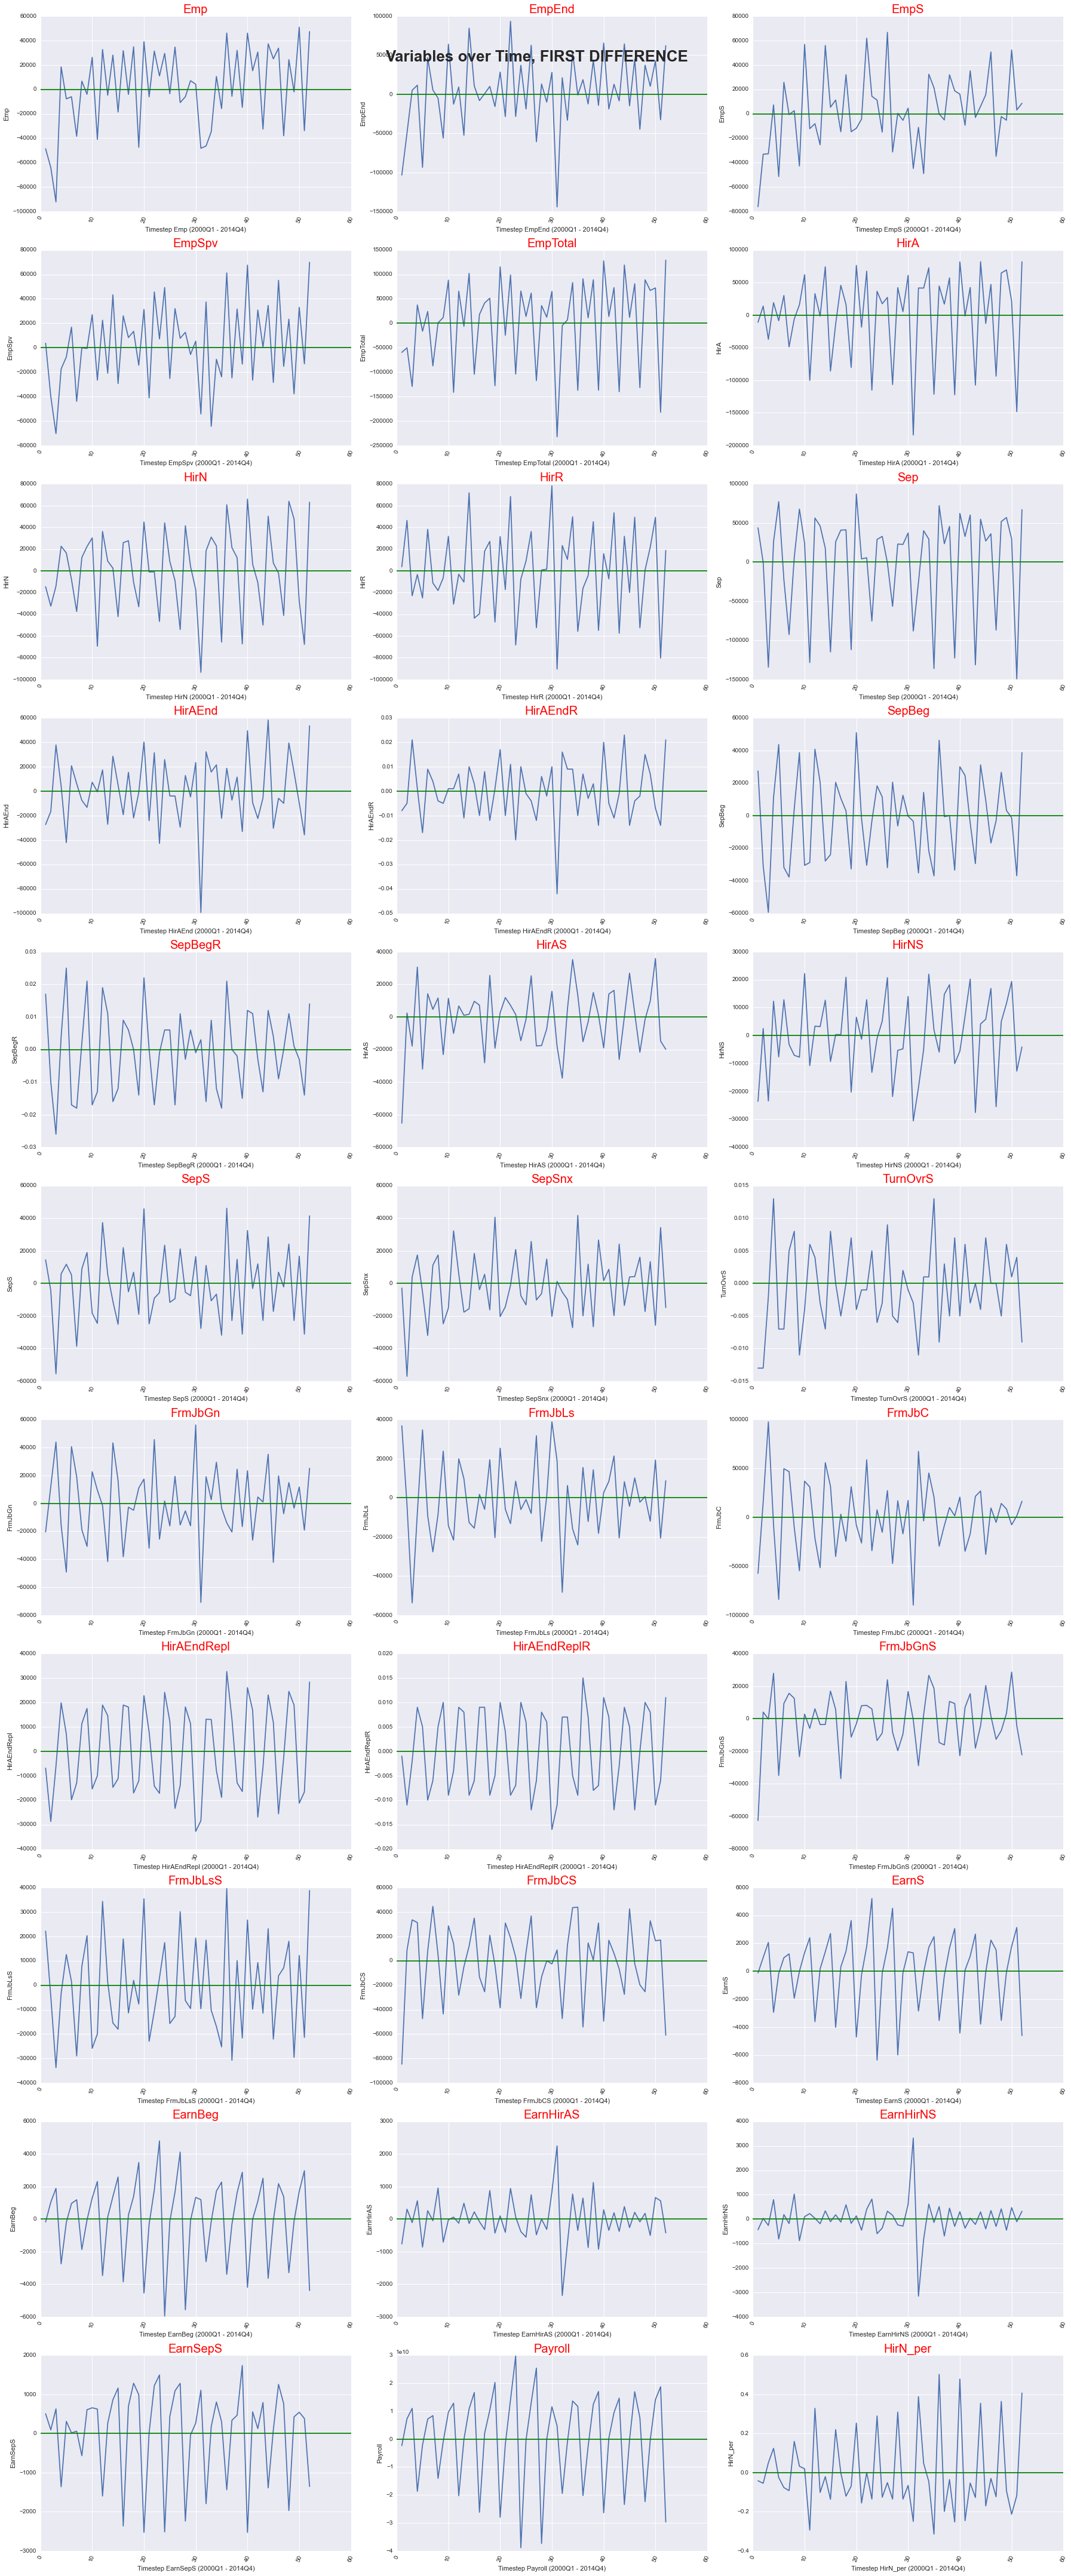

In [26]:
fig = pl.figure(figsize=(25,60))
fig.suptitle('Variables over Time, FIRST DIFFERENCE', fontweight='bold', fontsize=26)

x = 1
for i in cols:
    ax1 = fig.add_subplot(11,3,x)
    fig.tight_layout()
    ax1.plot(np.arange(len(data[i])), data[i] - data[i].shift(), label = 'all data')
    ax1.axhline(0, color = 'g')
    ax1.set_xlabel('Timestep {0} (2000Q1 - 2014Q4)'.format(i))
    ax1.set_ylabel('{0}'.format(i))
    ax1.set_title('Target Variable: % New Hires over Time')
    pl.xticks(rotation = 70)
    ax1.set_title(i, fontsize=20, color='r')
    x +=1

In [47]:
#variables for the PCA

inputs = ['EmpTotal', 'HirR', 'HirAEndR', 'SepBegR', 'HirAS', 
          'HirAEndReplR', 'EarnS', 'EarnHirNS']

/usr/local/lib/python3.4/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


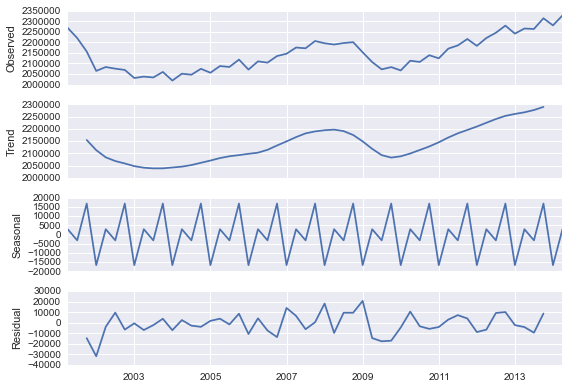

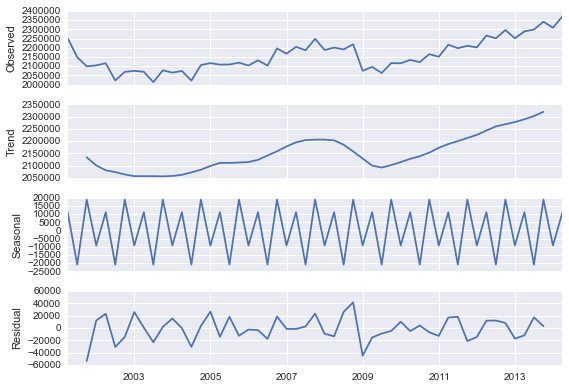

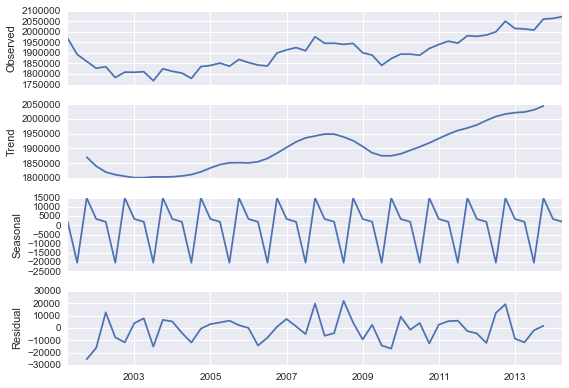

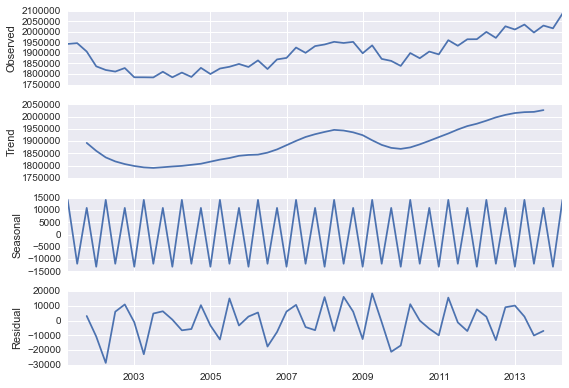

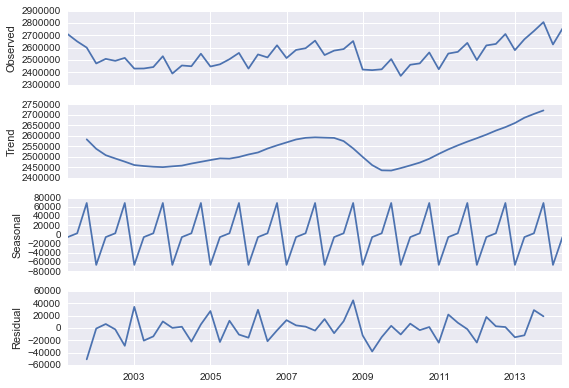

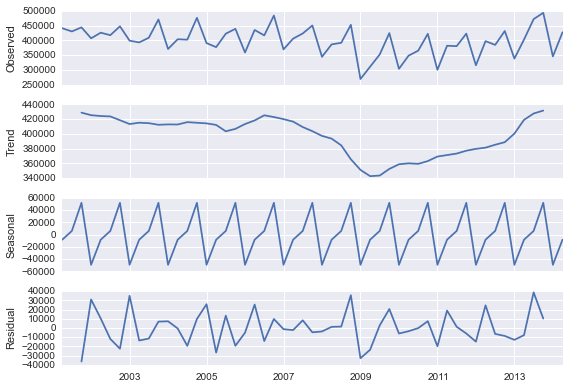

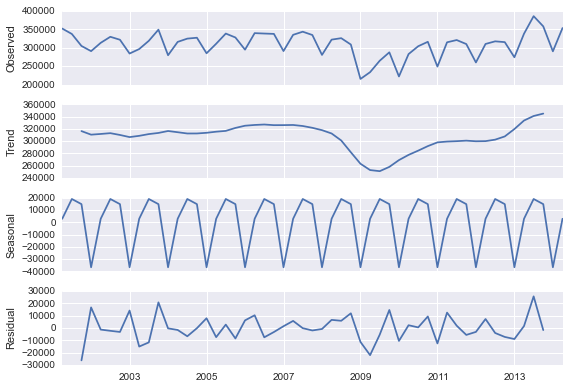

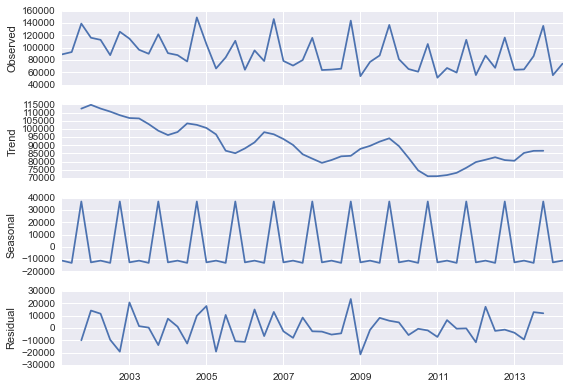

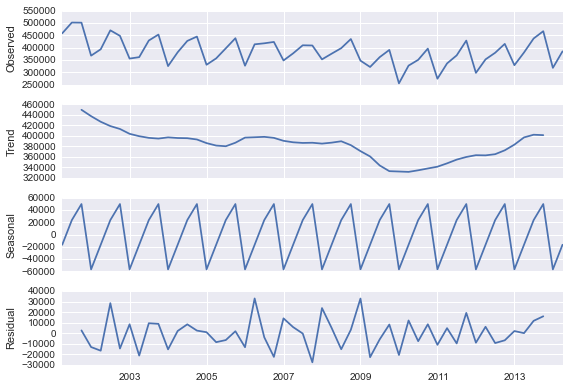

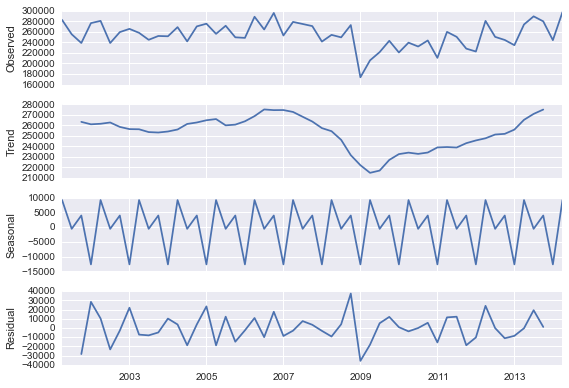

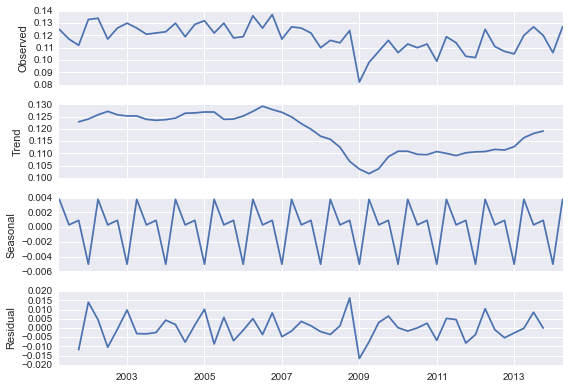

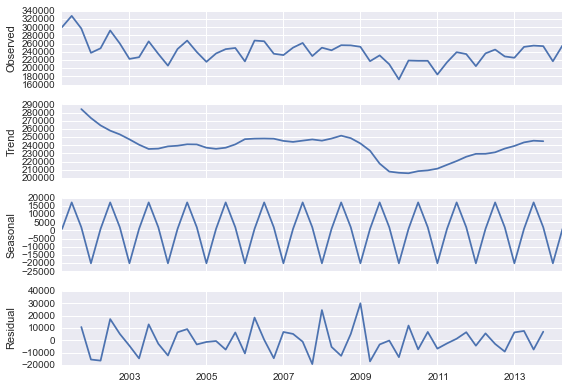

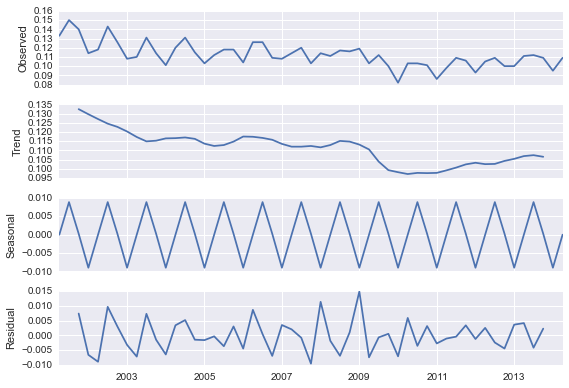

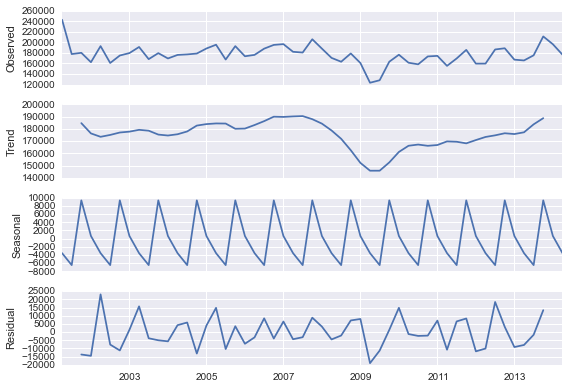

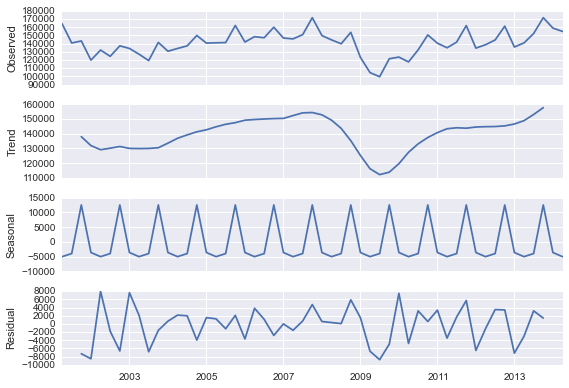

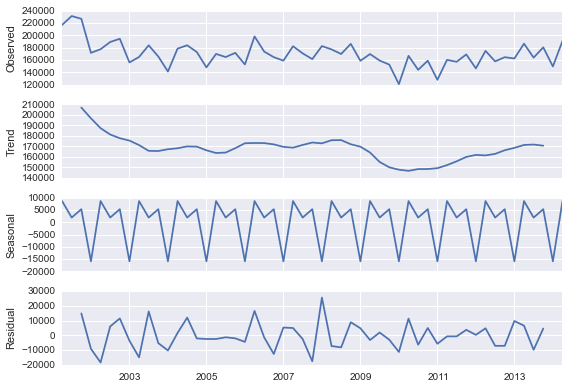

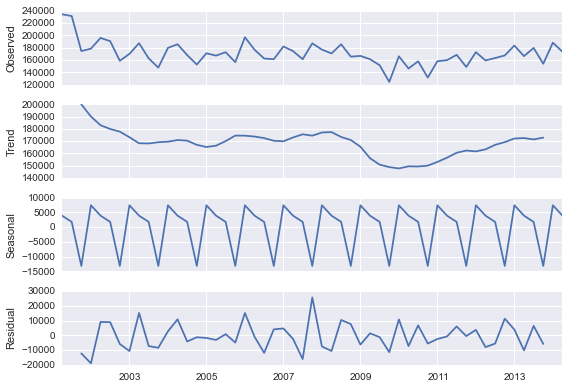

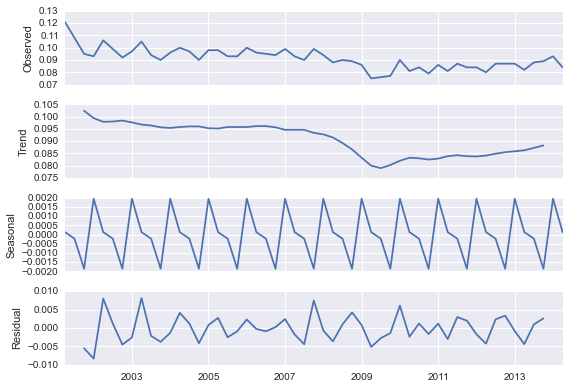

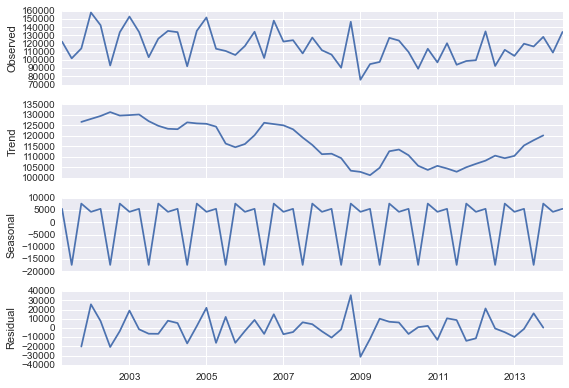

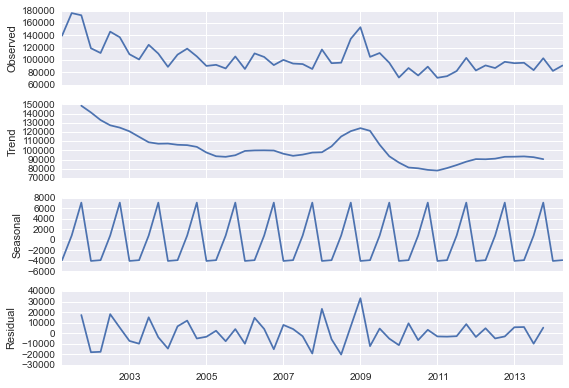

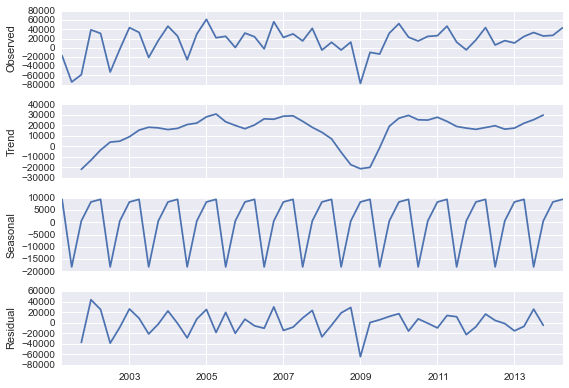

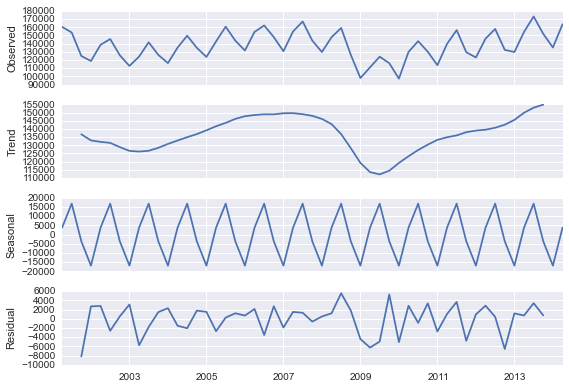

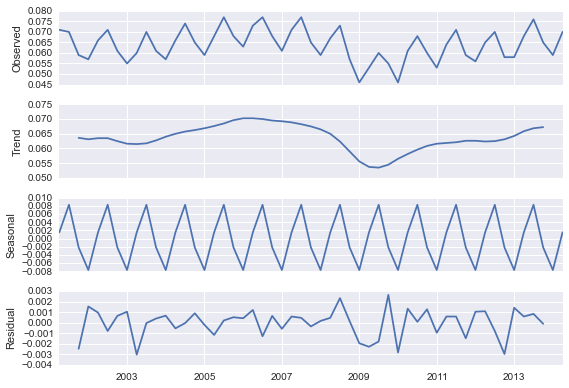

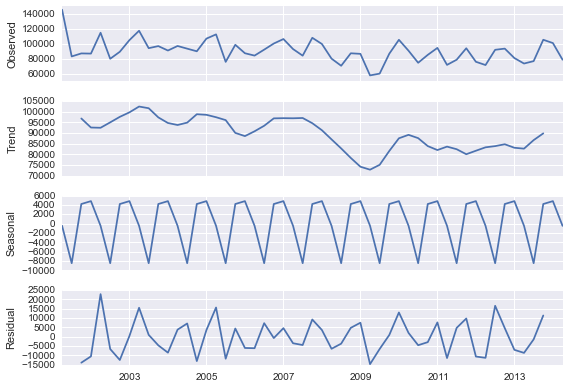

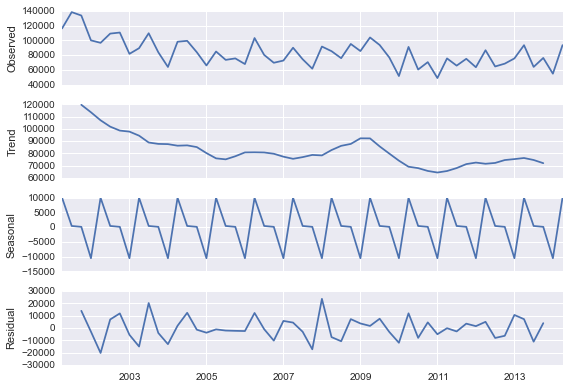

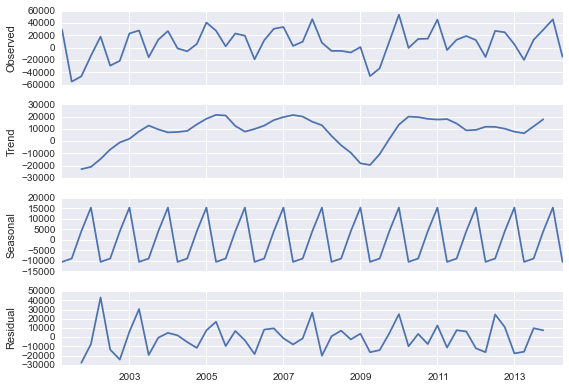

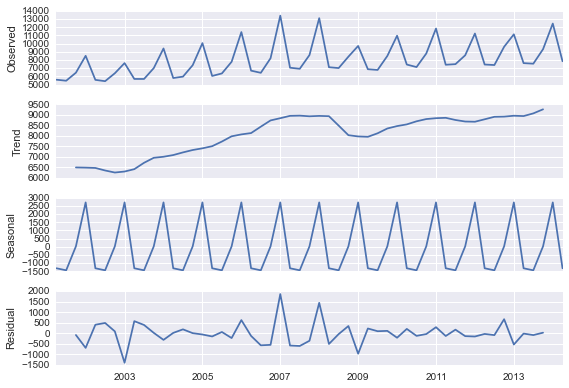

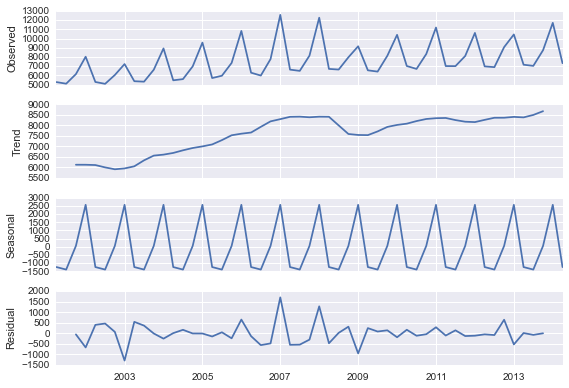

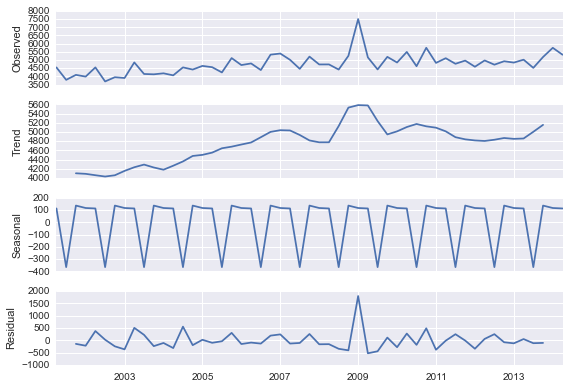

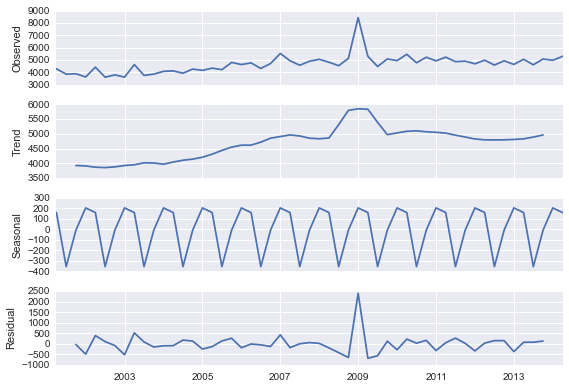

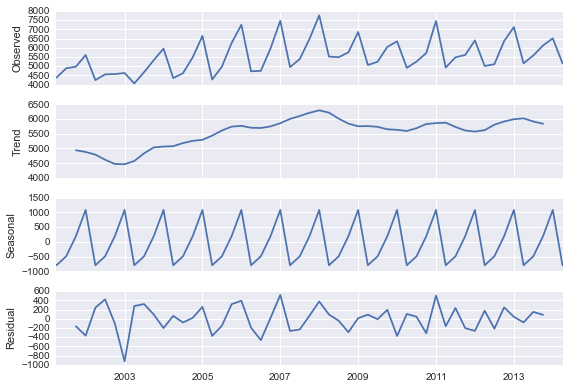

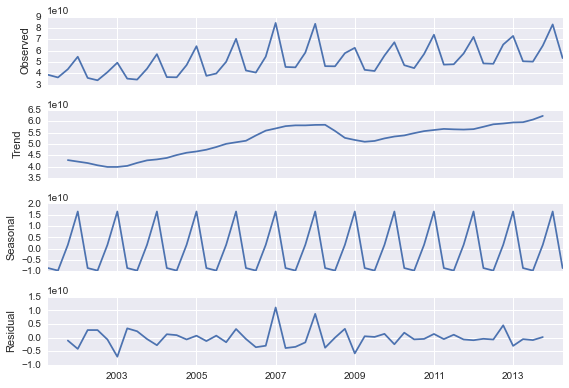

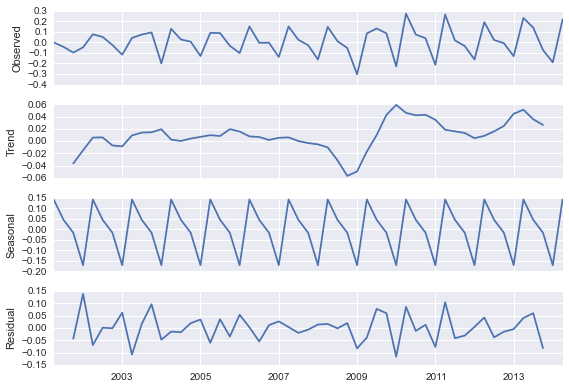

In [48]:
from statsmodels.tsa.seasonal import seasonal_decompose

fig = pl.figure(figsize=(25,60))
fig.suptitle('Variables over Time, DECOMPOSITION PLOT', fontweight='bold', fontsize=26)

x = 1
for i in cols:
    
    decomposition = seasonal_decompose(data[i])  
 
    #ax1 = fig.add_subplot(11,3,x)
    #fig.tight_layout()
    #ax1 = 
    decomposition.plot()  
    x +=1

In [49]:
# data.head()
# data.drop(['index'], axis=1, inplace=True)

/usr/local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


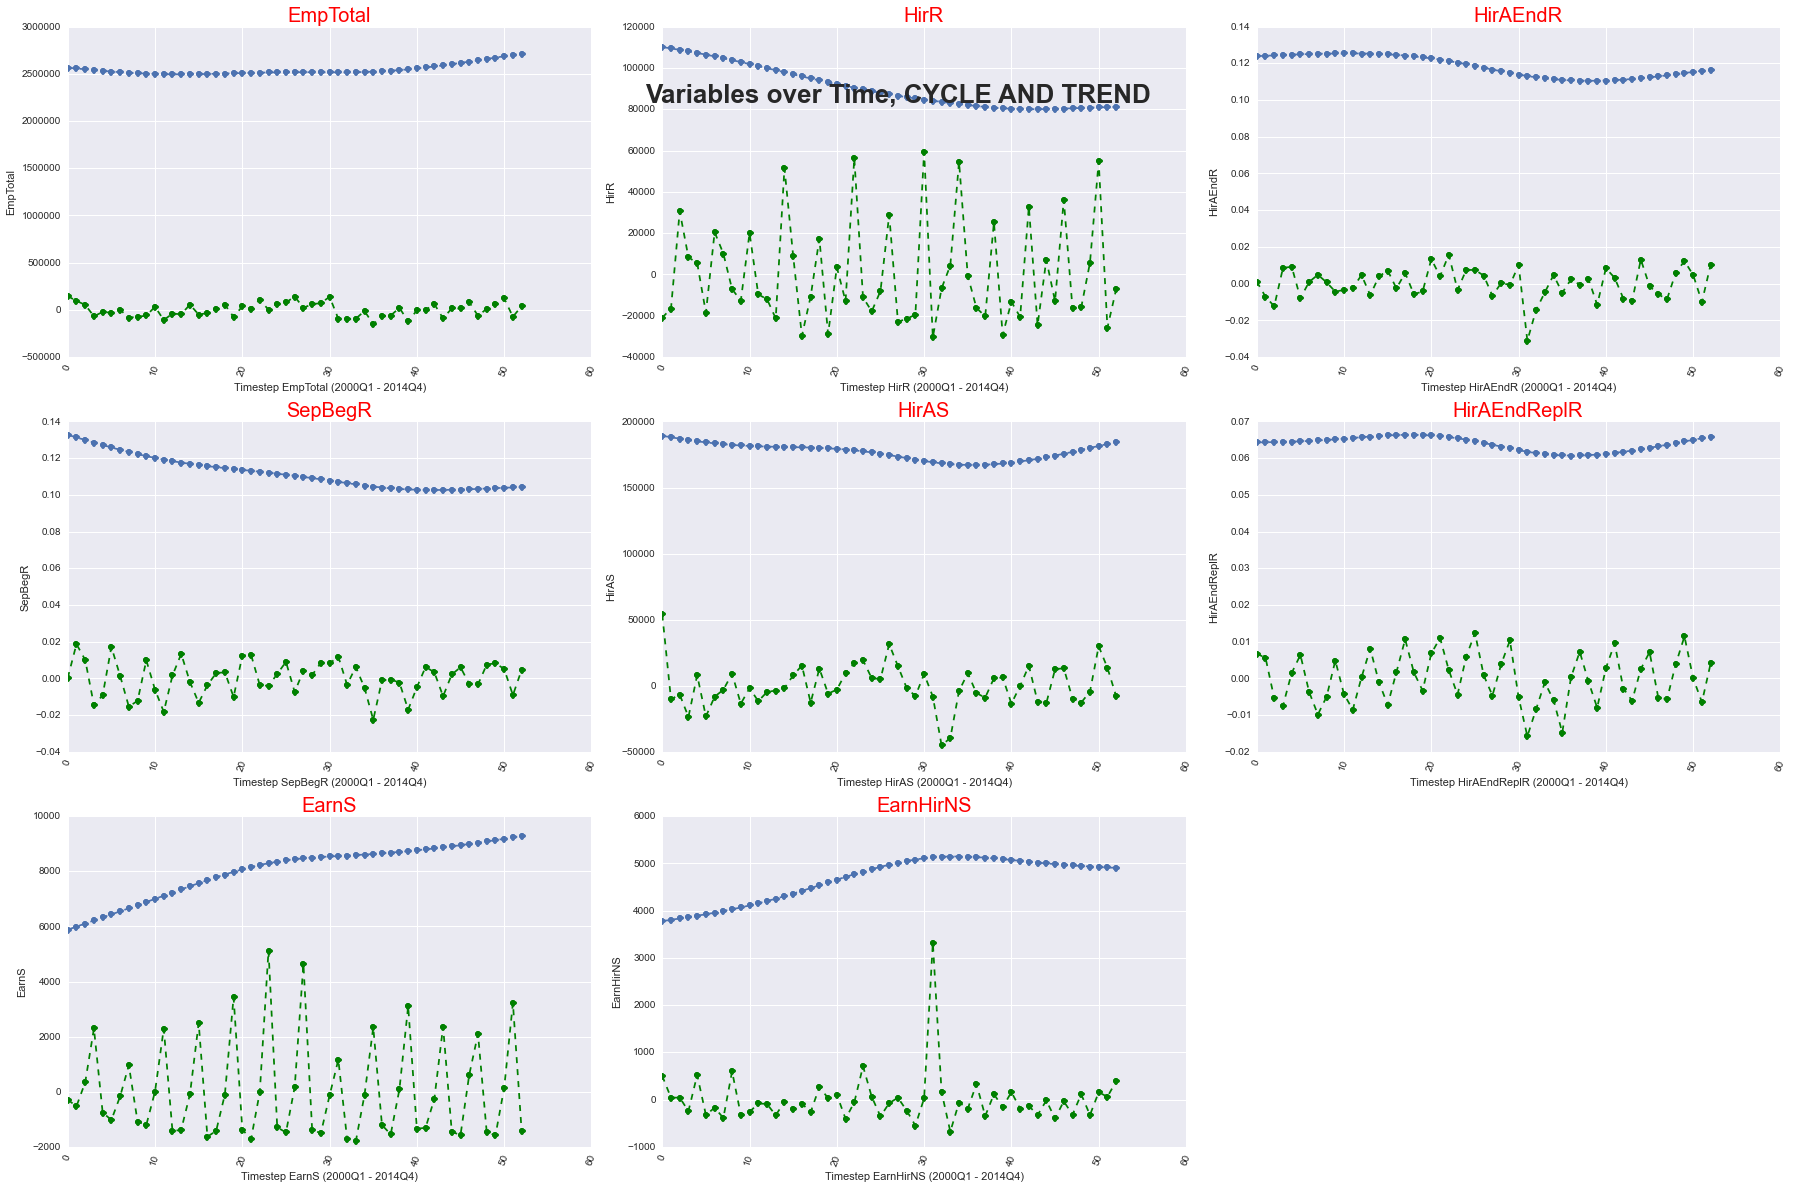

In [50]:
fig = pl.figure(figsize=(25,60))
fig.suptitle('Variables over Time, CYCLE AND TREND', fontweight='bold', fontsize=26)

cycles = {}

x = 1
#for i in cols:
for i in inputs:
    
    cycle, trend = sm.tsa.filters.hpfilter(data[i], 1600)
    cycles[i] = cycle
    
    ax1 = fig.add_subplot(11,3,x)
    fig.tight_layout()
    ax1.plot(cycle, marker='o', linestyle='--', color = 'g')  
    ax1.plot(trend, marker='o', linestyle='--')  
    ax1.set_xlabel('Timestep {0} (2000Q1 - 2014Q4)'.format(i))
    ax1.set_ylabel('{0}'.format(i))
    pl.xticks(rotation = 70)
    ax1.set_title(i, fontsize=20, color='r')
    ax1.legend()
    x +=1


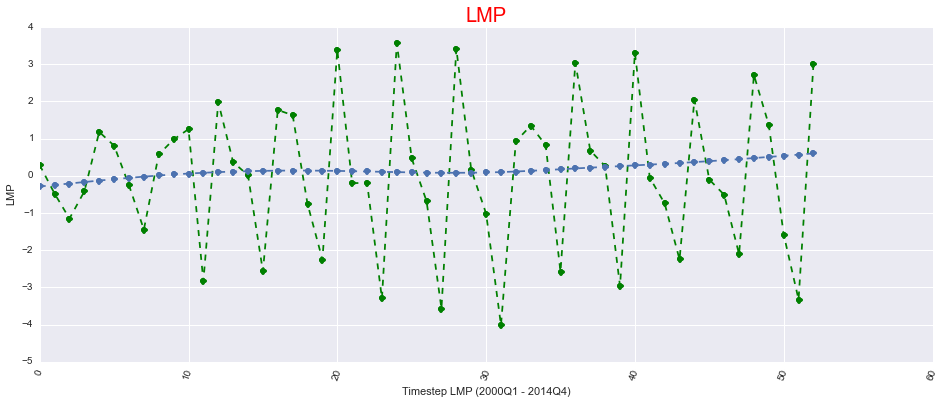

In [69]:
cycle, trend = sm.tsa.filters.hpfilter(data['LMP'], 1600)
HirN_per_trend = trend
fig, (ax1) = pl.subplots(figsize=(16,6), nrows=1, ncols=1)


ax1.plot(cycle, marker='o', linestyle='--', color = 'g')  
ax1.plot(trend, marker='o', linestyle='--')  
ax1.set_xlabel('Timestep LMP (2000Q1 - 2014Q4)')
ax1.set_ylabel('LMP')
pl.xticks(rotation = 70)
ax1.set_title('LMP', fontsize=20, color='r')


In [52]:
#save cycles into a new dataframe
input_cycles = pd.DataFrame(cycles)

In [53]:
input_cycles['LMP'] = data['LMP'].values

In [54]:
#Covariance Matrix
input_cycles.cov()

EarnHirNS           EarnS          EmpTotal  HirAEndR  \
EarnHirNS       297,817.690     160,095.241    -2,295,915.463    -1.775   
EarnS           160,095.241   3,188,240.708   -38,631,742.381    -5.217   
EmpTotal     -2,295,915.463 -38,631,742.381 5,423,766,303.047   259.482   
HirAEndR             -1.775          -5.217           259.482     0.000   
HirAEndReplR         -1.330          -8.093           245.691     0.000   
HirAS         1,251,206.273   6,757,001.622   616,521,672.728    21.166   
HirR         -1,456,527.872  -2,208,019.778   884,892,586.453    75.940   
SepBegR               0.362          -9.012           324.338    -0.000   
LMP                -240.766      -2,891.711        35,608.949     0.009   

              HirAEndReplR           HirAS            HirR  SepBegR        LMP  
EarnHirNS           -1.330   1,251,206.273  -1,456,527.872    0.362   -240.766  
EarnS               -8.093   6,757,001.622  -2,208,019.778   -9.012 -2,891.711  
EmpTotal           245.691 616,521,672.728 884,892,586.453  324.338 35,608.949  
HirAEndR             0.000          21.166          75.940   -0.000      0.009  
HirAEndReplR         0.000           6.945         -31.628    0.000      0.008  
HirAS                6.945 269,223,214.877  83,371,271.707  -19.873 -8,411.811  
HirR               -31.628  83,371,271.707 626,652,260.550  -12.730   -745.653  
SepBegR              0.000         -19.873         -12.730    0.000      0.006  
LMP                  0.008      -8,411.811        -745.653    0.006      3.944

**Principle Component Analysis, v1**

(using all columns -- doing with sklearn)

In [55]:
#convert dataframe to a numpy array
sk_data= input_cycles.as_matrix()
print(sk_data.shape)

#drop the first three columns: period, year, quarter -- all that remains are the numeric indicator columns
y = sk_data[:,-1]
X = sk_data[:,:-1]
# print(X.shape)
# print(y.shape)



(53, 9)


In [56]:
#CYCLES OF DATA:

principles = 3

pca = sk.decomposition.PCA(n_components = principles)
pca.fit(X)
X_t = pca.transform(X)
#printout of the variance explained by each column
with printoptions(precision=3, suppress=True):
    print('PCA WITH FEATURES NORMALIZED, Explained Variance Ratio:\n', pca.explained_variance_ratio_) 

#get the weights of each of the features by vector space
i = np.identity(X.shape[1])

coef = pca.transform(i)
weights = pd.DataFrame(coef, columns=['PC-1', 'PC-2', 'PC-3'],
                       index=inputs)


print('PCA PARAMETERS:\n', pca.get_params(),'\n')

pd.options.display.float_format = '{:,.3f}'.format
print('PCA WEIGHTS: \n', weights)
    

PCA WITH FEATURES NORMALIZED, Explained Variance Ratio:
 [ 0.894  0.075  0.031]
PCA PARAMETERS:
 {'n_components': 3, 'whiten': False, 'copy': True} 

PCA WEIGHTS: 
                PC-1   PC-2   PC-3
EmpTotal     -0.000  0.002 -0.007
HirR         -0.007 -0.008 -0.060
HirAEndR      0.978  0.164  0.128
SepBegR      -0.000 -0.000  0.000
HirAS        -0.000  0.000  0.000
HirAEndReplR  0.115  0.094 -0.987
EarnS         0.174 -0.982 -0.073
EarnHirNS    -0.000  0.000  0.000


In [57]:
#NORMALIZED CYCLES OF DATA:

X_norm = sk.preprocessing.normalize(X, norm='l2', axis=0, copy=True)

principles = 3

pca = sk.decomposition.PCA(n_components = principles)
pca.fit(X_norm)
X_norm_t = pca.transform(X_norm)
#printout of the variance explained by each column
with printoptions(precision=3, suppress=True):
    print('PCA WITH FEATURES NORMALIZED, Explained Variance Ratio:\n', pca.explained_variance_ratio_) 

#get the weights of each of the features by vector space
i = np.identity(X_norm.shape[1])

coef = pca.transform(i)
weights = pd.DataFrame(coef, columns=['PC-1', 'PC-2', 'PC-3'],
                       index=inputs)


print('PCA PARAMETERS:\n', pca.get_params(),'\n')

pd.options.display.float_format = '{:,.3f}'.format
print('PCA WEIGHTS: \n', weights)

PCA WITH FEATURES NORMALIZED, Explained Variance Ratio:
 [ 0.362  0.223  0.169]
PCA PARAMETERS:
 {'n_components': 3, 'whiten': False, 'copy': True} 

PCA WEIGHTS: 
                PC-1   PC-2   PC-3
EmpTotal     -0.211  0.015 -0.664
HirR         -0.434  0.306 -0.032
HirAEndR      0.443  0.346 -0.297
SepBegR       0.372  0.259  0.412
HirAS         0.510 -0.235 -0.001
HirAEndReplR  0.088  0.535 -0.326
EarnS         0.154  0.522  0.098
EarnHirNS     0.375 -0.325 -0.429


In [58]:
#print('PCA WEIGHTS, PC-1 >0.1: \n', weights[weights['PC-1'].abs() > 0.1])

In [59]:
regress = pd.DataFrame(X_norm_t, columns=['PC_1', 'PC_2', 'PC_3'])
regress['y'] = y
regress['y'] = regress['y'].convert_objects(convert_numeric=True)

In [60]:
X1 = regress[['PC_1', 'PC_2', 'PC_3']]
y1 = regress['y']

In [61]:
X1 = sm.add_constant(X1)
est = sm.OLS(y1, X1).fit()

b = est.params

pca_HirN_per = b[0] + b[1]*X_norm_t[:,0] + b[2]*X_norm_t[:,1] + b[3]*X_norm_t[:,2];


est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     22.40
Date:                Tue, 24 Nov 2015   Prob (F-statistic):           2.84e-09
Time:                        16:06:46   Log-Likelihood:                -88.178
No. Observations:                  53   AIC:                             184.4
Df Residuals:                      49   BIC:                             192.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.1552      0.182      0.851      0.399        -0.211     0.522
PC_1           5.4965      0.781      7.040      0.000         3.927     7.066
PC_2          -3.3602      0.994     -3.382      0.001        -5.357    -1.364
PC_3           2.8493      1.144      2.492      0.016         0.551     5.147
==============================================================================
Omnibus:                        3.549   Durbin-Watson:                   2.795
Prob(Omnibus):                  0.170   Jarque-Bera (JB):                2.886
Skew:                           0.452   Prob(JB):                        0.236
Kurtosis:                       2.299   Cond. No.                         6.27
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
regress2 = pd.DataFrame(X_norm, columns=inputs)

regress2['y'] = y
regress2['y'] = regress2['y'].convert_objects(convert_numeric=True)


X2 = regress2.ix[:,0:-1]
y2 = regress2['y']

X2 = sm.add_constant(X2)
est2 = sm.OLS(y2, X2).fit()

est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     23.54
Date:                Tue, 24 Nov 2015   Prob (F-statistic):           1.59e-13
Time:                        16:06:46   Log-Likelihood:                -66.964
No. Observations:                  53   AIC:                             151.9
Df Residuals:                      44   BIC:                             169.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const            0.1552      0.129      1.203      0.235        -0.105     0.415
EmpTotal         0.1214      1.295      0.094      0.926        -2.489     2.732
HirR           -10.9009      1.530     -7.124      0.000       -13.985    -7.817
HirAEndR         4.1948      2.030      2.067      0.045         0.104     8.285
SepBegR          5.8136      1.602      3.628      0.001         2.585     9.043
HirAS           -2.9068      2.812     -1.034      0.307        -8.573     2.760
HirAEndReplR    -3.3142      1.476     -2.245      0.030        -6.289    -0.339
EarnS           -4.8007      1.751     -2.742      0.009        -8.330    -1.272
EarnHirNS       -1.9024      1.969     -0.966      0.339        -5.871     2.066
==============================================================================
Omnibus:                        2.535   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.282   Jarque-Bera (JB):                1.466
Skew:                          -0.055   Prob(JB):                        0.480
Kurtosis:                       2.193   Cond. No.                         28.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
b2 = est2.params

est_HirN_per = b2[0] + b2[1]*X_norm[:,0] + b2[2]*X_norm[:,1] + b2[3]*X_norm[:,2] + b2[4]*X_norm[:,3] 
+ b2[5]*X_norm[:,4] + b2[6]*X_norm[:,5] + b2[7]*X_norm[:,6] + b2[8]*X_norm[:,7];



<bound method AxesSubplot.legend of <matplotlib.axes._subplots.AxesSubplot object at 0x12c2380b8>>

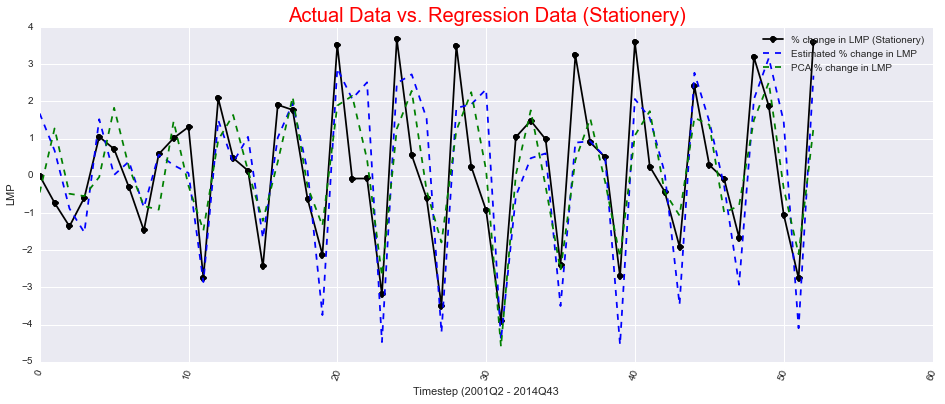

In [71]:
fig, (ax1) = pl.subplots(figsize=(16,6), nrows=1, ncols=1)


ax1.plot(y2, marker='o', linestyle='-', color = 'k', label = '% change in LMP (Stationery)')  
ax1.plot(est_HirN_per, linestyle='--', color = 'b', label = 'Estimated % change in LMP')  
ax1.plot(pca_HirN_per, linestyle='--', color = 'g', label = 'PCA % change in LMP')  

ax1.set_xlabel('Timestep (2001Q2 - 2014Q43')
ax1.set_ylabel('LMP')
pl.xticks(rotation = 70)
ax1.set_title('Actual Data vs. Regression Data (Stationery)', fontsize=20, color='r')
pl.legend()

ax1.legend
